<a href="https://colab.research.google.com/github/Egoago/Onlab/blob/main/%C3%96nlab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2D regression

##Preparing the data

###Defining the control points

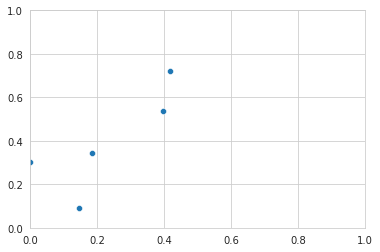

In [28]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

np.random.seed(1)
pointNum = 5
points = np.random.random((pointNum,2))
sns.scatterplot(x=points[:,0], y=points[:,1]).set(xlim=(0,1),ylim=(0,1));

###Defining training data generator

In [29]:
from tensorflow.keras.utils import Sequence
from math import ceil

class DataGenerator(Sequence):
  seed = 0
  def __init__(self, dataCount, batch_size, controlPoints):
    self.controlPoints = controlPoints
    self.dataCount = dataCount
    self.batch_size = batch_size
    self.seed = DataGenerator.seed
    DataGenerator.seed += 1
    self.randGen = np.random.default_rng(seed=self.seed)

  def __len__(self):
    return ceil(self.dataCount / self.batch_size)

  def dist(self, p):
    return np.linalg.norm(self.controlPoints-p, axis = 1).min()

  def __getitem__(self, idx):
    P = []
    d = []
    for i in range(self.batch_size):
      p = self.randGen.random(2)
      P.append(p)
      d.append(self.dist(p))
    return np.array(P), np.array(d)

  def on_epoch_end(self):
    self.randGen = np.random.default_rng(seed=self.seed)
  
  def getAll(self):
    self.on_epoch_end()
    P = []
    d = []
    for i in range(self.batch_size * self.__len__()):
      p = self.randGen.random(2)
      P.append(p)
      d.append(self.dist(p))
    self.on_epoch_end()
    return np.array(P), np.array(d)

###Creating generators

In [30]:
pointNum = 30000
validSplit = 0.1
testSplit  = 0.1
trainPointNum = int(pointNum*(1-validSplit-testSplit))
validPointNum = int(pointNum*validSplit)
testPointNum = int(pointNum*testSplit)

trainGen = DataGenerator(trainPointNum, 32, points)
validGen = DataGenerator(validPointNum, 32, points)
testGen = DataGenerator(testPointNum, 32, points)

##Creating model

In [31]:
from tensorflow.keras.models import Sequential
from tensorflow import norm
from tensorflow.math import reduce_sum, reduce_mean, square, abs
import tensorflow as tf
from tensorflow import keras

'''
  This part will be necessary when we will override the forward path
  instead of running it again during the process of calculationg
  the gradient of the model with respect of the input.
'''

class CustomModel(Sequential):
  def __init__(self, *args, **kwargs):
    Sequential.__init__(self, *args, **kwargs)
    self.stepCounter = 0
    self.eikonalLambda = 0.1

  def train_step(self, data):
    x, y = data
    trainableVariables = self.trainable_variables
    with tf.GradientTape() as backpropTape:
      backpropTape.watch(trainableVariables)

      surfacePred = self(points, training=True)
      with tf.GradientTape() as eikonalTape:
        eikonalTape.watch(x)
        volumePred = self(x, training=True)
      volumeGrad = eikonalTape.gradient(volumePred, x)
      
      surfaceLoss = reduce_mean(abs(surfacePred))
      eikonalLoss = reduce_mean((norm(volumeGrad, 2, -1) - 1) ** 2)
      
      loss = surfaceLoss + self.eikonalLambda * eikonalLoss
      loss += sum(model.losses)

    # gradients = backpropTape.gradient(loss, trainableVariables)
    #self.optimizer.apply_gradients(zip(gradients, trainableVariables))
    self.optimizer.minimize(loss, trainableVariables, tape=backpropTape)
    return {"loss": loss}
  
  def test_step(self, data):
    x, y = data
    surfacePred = self(points, training=False)
    with tf.GradientTape() as eikonalTape:
      eikonalTape.watch(x)
      volumePred = self(x, training=True)
    volumeGrad = eikonalTape.gradient(volumePred, x)
    
    surfaceLoss = reduce_sum(abs(surfacePred)) / 5.
    eikonalLoss = reduce_mean((norm(volumeGrad, 2, -1) - 1) ** 2)
    
    loss = surfaceLoss + self.eikonalLambda * eikonalLoss
    loss += sum(model.losses)
    return {"loss": loss}

Model: "custom_model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 64)                192       
_________________________________________________________________
dense_10 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 65        
Total params: 4,417
Trainable params: 4,417
Non-trainable params: 0
_________________________________________________________________


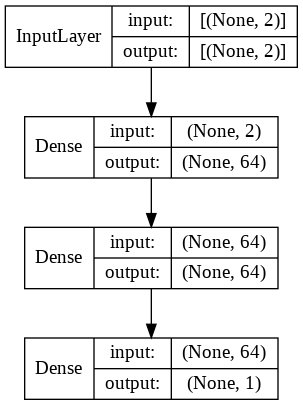

In [32]:
from tensorflow.keras.layers import Dense

model = CustomModel([
  Dense(64, activation='relu', kernel_initializer='he_normal', input_shape = (2,)),
  Dense(64, activation='relu', kernel_initializer='he_normal'),
  Dense(1, activation='linear')
])
model.summary()
keras.utils.plot_model(model, show_shapes=True, show_layer_names=False)

###Defining the loss function

In [33]:
from tensorflow.keras.callbacks import EarlyStopping

model.compile(optimizer = 'adam')
es = EarlyStopping(min_delta = 1e-5,
                        patience = 5,
                        verbose = 2,
                        restore_best_weights = True)

##Train

In [34]:
epochs = 50
history = model.fit(trainGen,
                    validation_data = validGen,
                    verbose = 1,
                    #callbacks = [es],
                    epochs = epochs)

Epoch 1/50
750/750 [==============================] - 2s 3ms/step - loss: 0.0143 - val_loss: 0.0051
Epoch 2/50
750/750 [==============================] - 2s 3ms/step - loss: 0.0070 - val_loss: 0.0032
Epoch 3/50
750/750 [==============================] - 2s 3ms/step - loss: 0.0067 - val_loss: 0.0038
Epoch 4/50
750/750 [==============================] - 2s 3ms/step - loss: 0.0067 - val_loss: 0.0099
Epoch 5/50
750/750 [==============================] - 2s 3ms/step - loss: 0.0057 - val_loss: 0.0065
Epoch 6/50
750/750 [==============================] - 2s 3ms/step - loss: 0.0066 - val_loss: 0.0021
Epoch 7/50
750/750 [==============================] - 2s 3ms/step - loss: 0.0054 - val_loss: 0.0014
Epoch 8/50
750/750 [==============================] - 2s 3ms/step - loss: 0.0055 - val_loss: 0.0065
Epoch 9/50
750/750 [==============================] - 2s 3ms/step - loss: 0.0047 - val_loss: 0.0025
Epoch 10/50
750/750 [==============================] - 2s 3ms/step - loss: 0.0048 - val_loss: 0.0037

##Evaluate

loss on test data: 0.0008827027631923556


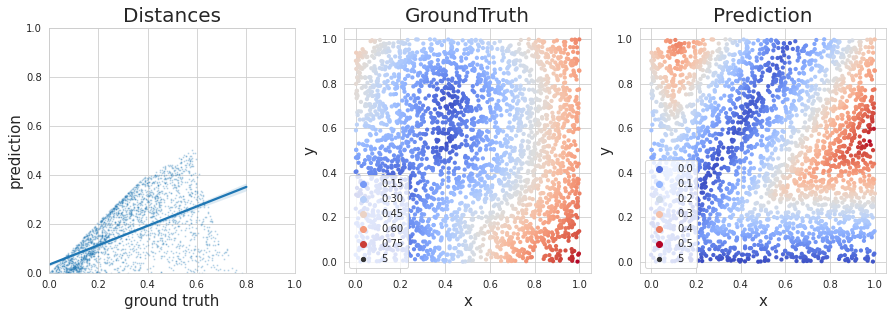

In [35]:
testX, testY = testGen.getAll()
print(f'loss on test data: {model.evaluate(testX, testY, verbose=0, batch_size=32)}')
prediction = model.predict(testX)
plots = []
sns.set_style("whitegrid")
fig, axs = plt.subplots(ncols = 3,
                        figsize=(15,4.5))
plots.append(sns.regplot(x = testY, y = prediction, ax=axs[0], scatter_kws={'s':1, 'alpha':0.2}))
plots.append(sns.scatterplot(x=testX[:,0], y=testX[:,1], hue = testY, size = 5, linewidth = 0, palette='coolwarm', ax=axs[1]))
plots.append(sns.scatterplot(x=testX[:,0], y=testX[:,1], hue = prediction.reshape(-1), size = 5, linewidth = 0, palette='coolwarm', ax=axs[2]))
plots[0].set_title('Distances', fontsize = 20)
plots[0].set_ylabel('prediction', fontsize = 15)
plots[0].set(ylim=(0,1),xlim=(0,1))
plots[0].set_xlabel('ground truth', fontsize = 15)
plots[1].set_xlabel('x', fontsize = 15)
plots[1].set_ylabel('y', fontsize = 15)
plots[1].set_title('GroundTruth', fontsize = 20)
plots[2].set_xlabel('x', fontsize = 15)
plots[2].set_ylabel('y', fontsize = 15)
plots[2].set_title('Prediction', fontsize = 20);

##Plot Model

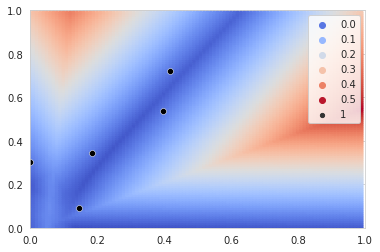

In [36]:
resolution = 100
grid = np.empty((resolution*resolution,2))
for y in range(resolution):
  for x in range(resolution):
    grid[y*resolution+x] = [x/resolution, y/resolution]
prediction = model.predict(grid)
sns.scatterplot(x=grid[:,0],
                y=grid[:,1],
                hue = prediction.reshape(-1),
                size = 1,
                linewidth = 0,
                palette='coolwarm')
sns.scatterplot(x=points[:,0],
                y=points[:,1],
                color = 'black').set(xlim=(0,1),ylim=(0,1));
